In [1]:
#!pip3 install numpy
#!pip3 install xgboost
#!pip3 install sklearn

In [2]:
#!pip3 install joblib

In [3]:
#!pip3 install pandas

In [4]:
#!pip3 install recsim_ng

In [1]:
import functools
import numpy as np
import sklearn.preprocessing
import scipy.special

import sklearn.model_selection
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
import pandas as pd
from joblib import Parallel, delayed

def get_simulation_variables(
        num_users = 1000,
        horizon = 1,
        slate_size = 10,
        num_docs = 100,
        user_initial_budget = None,
        doc_costs = None,
        doc_relevances = None,
        user_slates = None,
        default_no_choice_logit = 4.0,
        seed = 0):
    import tensorflow as tf

    tf.random.set_seed(
        seed
    )

    num_topics = 2
    config = {
        "slate_size": slate_size,
        "num_users": num_users,
        "num_topics": num_topics,
        "num_docs": num_docs
    }

    from recsim_ng.core import variable
    from recsim_ng.entities.recommendation import user
    from typing import Any, Callable, Mapping, Sequence, Text
    import edward2 as ed
    from recsim_ng.entities.choice_models import selectors
    from recsim_ng.core import value
    from recsim_ng.lib.tensorflow import field_spec
    from gym import spaces
    from recsim_ng.entities.recommendation import corpus
    from recsim_ng.entities.recommendation import recommender


    Value = value.Value
    ValueSpec = value.ValueSpec
    Space = field_spec.Space
    FieldSpec = value.FieldSpec
    Variable = variable.Variable

    class UserWithPredefBudget(user.User):
        def __init__(self,
                     config : Mapping[Text, Any],
                     initial_budget : None,
                     default_no_choice_logit : tf.constant(1.0, tf.float32),
                     name : Text = "UserWithBudget") -> None:

            super().__init__(config, name)
            self.slate_size = config.get("slate_size")

            self.default_no_choice_logit = default_no_choice_logit * tf.ones(self._num_users)
            self.initial_budget = ed.Deterministic(initial_budget.astype(np.float32))
            self.choice_model = selectors.MultinomialLogitChoiceModel(
                batch_shape=(self._num_users,), nochoice_logits= self.default_no_choice_logit)

        def initial_state(self) -> Value:
            return Value(budget = self.initial_budget)

        def generate_watched_vector(self, slate_doc_costs, previous_state) :
            cumulative_cost = tf.cumsum(slate_doc_costs, axis = 1)
            temp = previous_state.get('budget')[..., tf.newaxis]
            watched = tf.where(cumulative_cost < temp,
                               tf.ones_like(cumulative_cost),
                               tf.zeros_like(cumulative_cost))
            return watched

        def next_state(self, previous_state : Value, slate_docs: Value) -> Value:
            return Value(budget = previous_state.get('budget'))

        def next_response(self, previous_state: Value, slate_docs : Value) -> Value:

            #relevances are in log-scale
            slate_doc_relevances = slate_docs.get('relevances')
            slate_doc_costs = slate_docs.get('costs')

            watched = self.generate_watched_vector(slate_doc_costs, previous_state)

            adjusted_scores = watched * slate_doc_relevances
            adjusted_scores_1 = tf.where(adjusted_scores == 0,
                                         tf.constant(-np.Inf, tf.float32) * tf.ones_like(adjusted_scores),
                                         adjusted_scores)

            return Value(choice = self.choice_model.choice(adjusted_scores_1).get("choice"),
                         logits = tf.concat((adjusted_scores_1, self.default_no_choice_logit[..., tf.newaxis]), axis = -1),
                         watched = watched)

        def observation(self):
            pass

        def specs(self) -> ValueSpec:
            response_spec = ValueSpec(
                choice = selectors.MultinomialLogitChoiceModel(
                    batch_shape=(self._num_users,), nochoice_logits= tf.ones(self._num_users)).specs().get("choice"),

                logits = Space(spaces.Box(-np.Inf, np.Inf, shape = (self._num_users, self.slate_size + 1))),

                watched = Space(spaces.Box(-np.Inf, np.Inf, shape = (self._num_users, self.slate_size)))
            )
            state_spec = ValueSpec(budget = FieldSpec())
            return state_spec.prefixed_with('state').union(
                response_spec.prefixed_with('response'))

    # Set up ground truth runtime.
    gt_user_ctor = functools.partial(
        UserWithPredefBudget,
        default_no_choice_logit = tf.constant(default_no_choice_logit, tf.float32),
        initial_budget=user_initial_budget)

    #Define Corpus of Items
    class RelevanceAndCostCorpus(corpus.Corpus):
        def __init__(self,
                     config,
                     doc_costs,
                     doc_relevances,
                     name = "RelevanceAndCostCorpus"):
            super().__init__(config, name)
            self.doc_costs = ed.Deterministic(doc_costs.astype(np.float32))
            self.doc_relevances = ed.Deterministic(doc_relevances.astype(np.float32))

        def specs(self):
            state_spec = ValueSpec(relevances = FieldSpec(),
                                   costs = FieldSpec())
            return state_spec.prefixed_with('state').union(
                state_spec.prefixed_with("available_docs"))

        def initial_state(self):
            return Value(relevances = self.doc_relevances, costs = self.doc_costs)

        def next_state(self, previous_state):
            return previous_state.map(ed.Deterministic)

        def available_documents(self, corpus_state):
            """The available_documents value."""
            return corpus_state.map(ed.Deterministic)

    gt_corpus_ctor = functools.partial(
        RelevanceAndCostCorpus,
        doc_costs = doc_costs,
        doc_relevances = doc_relevances)

    class PrecomputedSlatesRecommender(recommender.BaseRecommender):

        def __init__(self,
                     config,
                     user_slates):

            recommender.BaseRecommender.__init__(self, config)
            self.user_slates = user_slates

        def slate_docs(self, user_state, corpus_state):

            del user_state #not using user state
            doc_relevances = corpus_state.get('relevances')
            doc_costs = corpus_state.get('costs')
            doc_relevances_rep = tf.repeat(doc_relevances[tf.newaxis], self._num_users, axis = 0)
            doc_costs_rep = tf.repeat(doc_costs[tf.newaxis], self._num_users, axis = 0)

            slate_doc_relevances = tf.gather(doc_relevances_rep,
                                             self.user_slates,
                                             axis = 1,
                                             batch_dims=1)

            slate_doc_costs = tf.gather(doc_costs_rep,
                                        self.user_slates,
                                        axis = 1,
                                        batch_dims=1)

            return Value(relevances = slate_doc_relevances,
                         costs = slate_doc_costs,
                         indices = self.user_slates)

        def initial_state(self):
            pass

        def next_state(self):
            pass

        def specs(self):
            output_shape_relevance = (self._num_users, self._slate_size)
            slate_docs_spec = ValueSpec(
                relevances=Space(
                    spaces.Box(low=0, high=np.Inf, shape=output_shape_relevance)),
                costs=Space(
                    spaces.Box(low=0, high=np.Inf, shape=output_shape_relevance)),
                indices=Space(
                    spaces.Box(low=0, high=self._num_docs, shape=output_shape_relevance)))
            return slate_docs_spec.prefixed_with('slate')
    gt_recommender_ctor = functools.partial(
        PrecomputedSlatesRecommender,
        user_slates=user_slates
    )

    def my_recs_story(config,
                      user_ctor,
                      corpus_ctor,
                      recommender_ctor):

        user = user_ctor(config)
        user_spec = user.specs()

        corpus = corpus_ctor(config)
        corpus_spec = corpus.specs()

        recommender = recommender_ctor(config)
        recommender_spec = recommender.specs()

        ##Simulation variables
        corpus_state = Variable(name = "corpus state", spec = corpus_spec.get("state"))
        slate_docs = Variable(name = "slate docs", spec = recommender_spec.get("slate"))
        user_response = Variable(name = "user response", spec = user_spec.get("response"))
        user_state = Variable(name = "user state", spec = user_spec.get("state"))
        ###


        ##Initialize simulation variables
        corpus_state.initial_value = variable.value(corpus.initial_state)
        user_state.initial_value = variable.value(user.initial_state)
        slate_docs.initial_value = variable.value(recommender.slate_docs, (user_state, corpus_state))
        user_response.initial_value = variable.value(user.next_response, (user_state, slate_docs))
        ###

        ##Transition definition of simulation variables
        ## Does the order matter
        corpus_state.value = variable.value(corpus.next_state, (corpus_state.previous,))
        user_state.value = variable.value(user.next_state, (user_state.previous, slate_docs.previous))
        slate_docs.value = variable.value(recommender.slate_docs, (user_state, corpus_state))
        user_response.value = variable.value(user.next_response, (user_state, slate_docs))

        return [corpus_state, user_state, slate_docs, user_response]

    gt_variables = my_recs_story(config,
                                 gt_user_ctor,
                                 gt_corpus_ctor,
                                 gt_recommender_ctor)

    return gt_variables


def get_simulation_data(num_users = 1000,
                        horizon = 1,
                        slate_size = 10,
                        num_docs = 100,
                        user_initial_budget = None,
                        doc_costs = None,
                        doc_relevances = None,
                        user_slates = None,
                        default_no_choice_logit = 4.0,
                        seed = 0):

    from recsim_ng.core import network as network_lib
    from recsim_ng.lib.tensorflow import runtime

    gt_variables = get_simulation_variables(num_users,
                                            horizon,
                                            slate_size,
                                            num_docs,
                                            user_initial_budget,
                                            doc_costs,
                                            doc_relevances,
                                            user_slates,
                                            default_no_choice_logit,
                                            seed)

    gt_network = network_lib.Network(variables=gt_variables)
    gt_runtime = runtime.TFRuntime(network=gt_network)
    traj = dict(gt_runtime.trajectory(length=horizon))
    return traj


def compute_metrics(traj, slate_size, num_users):
    choice = traj['user response'].as_dict['choice'].numpy()[0]
    slate_level_response = choice != slate_size
    play_rate = slate_level_response.sum() / num_users

    impression = traj['user response'].as_dict['watched'].numpy()[0]
    return play_rate, np.mean(impression.sum(axis = 1))

def learn_optimal_q_function(traj,
                             xgb_model,
                             call_count,
                             discount_factor,
                             num_users,
                             slate_size,
                             all_item_relevances,
                             all_item_costs,
                             num_iter):

    feature_data= \
        generate_feature_data(num_users, slate_size, traj)

    immediate_reward = feature_data[0]
    stacked_training_features = feature_data[1]
    pregenerate_indices_for_next_state_action = feature_data[2]
    validation_positive_pages_repeated = feature_data[3]
    validation_positive_page_features = feature_data[4]
    validation_negative_pages_repeated = feature_data[5]
    validation_negative_page_features = feature_data[6]
    slates_above_list = feature_data[7]
    #print(slates_above_list)

    xgb_model = train_xgb_model_for_qlearning(immediate_reward,
                                              xgb_model,
                                              stacked_training_features,
                                              pregenerate_indices_for_next_state_action,
                                              call_count,
                                              discount_factor,
                                              slates_above_list,
                                              all_item_relevances,
                                              all_item_costs,
                                              num_iter)

    auc_score = compute_auc_score(xgb_model,
                                  validation_positive_pages_repeated,
                                  validation_positive_page_features,
                                  validation_negative_pages_repeated,
                                  validation_negative_page_features)

    return xgb_model, auc_score

def update_q_function(traj, xgb_model, call_count, discount_factor, num_users, slate_size):

    feature_data= \
        generate_feature_data(num_users, slate_size, traj)

    immediate_reward = feature_data[0]
    stacked_training_features = feature_data[1]
    pregenerate_indices_for_next_state_action = feature_data[2]
    validation_positive_pages_repeated = feature_data[3]
    validation_positive_page_features = feature_data[4]
    validation_negative_pages_repeated = feature_data[5]
    validation_negative_page_features = feature_data[6]

    xgb_model = train_xgb_model(immediate_reward,
                                xgb_model,
                                stacked_training_features,
                                pregenerate_indices_for_next_state_action,
                                call_count,
                                discount_factor)

    auc_score = compute_auc_score(xgb_model,
                                  validation_positive_pages_repeated,
                                  validation_positive_page_features,
                                  validation_negative_pages_repeated,
                                  validation_negative_page_features)

    return xgb_model, auc_score


def generate_feature_data(num_users, slate_size, traj):

    feature_df = unroll_traj_in_feature_df(num_users, slate_size, traj)

    page_level_labels = feature_df.groupby('page_ind')['label'].sum().reset_index()

    positive_pages = page_level_labels[page_level_labels.label == 1].page_ind.values

    negative_pages = page_level_labels[page_level_labels.label == 0].page_ind.values

    #print('positive_pages.shape, negative_pages.shape: ', positive_pages.shape, negative_pages.shape)

    (training_positive_pages, validation_positive_pages,
     training_negative_pages, validation_negative_pages) = give_train_test_split(positive_pages, negative_pages)

    training_feature_df = \
        feature_df[feature_df.page_ind.isin(np.concatenate([training_positive_pages, training_negative_pages]))]
    training_feature_df = training_feature_df.sort_values(by = ['page_ind', 'row_position'])

    immediate_reward = training_feature_df.label.values

    stacked_training_features = featurize(training_feature_df)
    slates_above_list = construct_slates_above(training_feature_df)

    temp = feature_df[feature_df.page_ind.isin(validation_positive_pages)]
    temp = temp.sort_values(by = ['page_ind', 'row_position'])

    validation_positive_pages_repeated = temp.page_ind.values

    validation_positive_page_features = featurize(temp)

    temp = feature_df[feature_df.page_ind.isin(validation_negative_pages)]
    temp = temp.sort_values(by = ['page_ind', 'row_position'])
    validation_negative_pages_repeated = temp.page_ind.values

    validation_negative_page_features = featurize(temp)

    pre_generated_ids_for_next_state_action = \
        pre_generate_ids_for_next_state_action(training_feature_df.page_ind.values,
                                               np.unique(training_feature_df.page_ind.values))

    return (immediate_reward,
            stacked_training_features,
            pre_generated_ids_for_next_state_action,
            validation_positive_pages_repeated,
            validation_positive_page_features,
            validation_negative_pages_repeated,
            validation_negative_page_features,
            slates_above_list)

def construct_slates_above(feature_df):
    slates_above_list = []
    slates_above_for_current_page = []
    prev_page_ind = -1
    for ind, row in feature_df.iterrows():
        if row.page_ind != prev_page_ind:
            slates_above_for_current_page = []
        slates_above_list.append(slates_above_for_current_page)
        slates_above_for_current_page = list.copy(slates_above_for_current_page)
        slates_above_for_current_page.append(int(row.video_id))
        prev_page_ind = row.page_ind

    return slates_above_list

def train_xgb_model_for_qlearning(immediate_reward,
                                  xgb_model,
                                  stacked_training_features,
                                  pre_generated_ids_for_next_state_action,
                                  call_count,
                                  discount_factor,
                                  slates_above_list,
                                  all_item_relevances,
                                  all_item_costs,
                                  num_iter):


    #repeat each row num_items times
    repeated_stacked_training_features = np.repeat(stacked_training_features,
                                                   all_item_relevances.shape[0],
                                                   axis = 0)
    #repeat the entire relevance and cost array num_samples times
    repeated_relevances = np.tile(all_item_relevances, (stacked_training_features.shape[0]))
    repeated_costs = np.tile(all_item_costs,(stacked_training_features.shape[0]))

    repeated_stacked_training_features[:, 1] = repeated_relevances
    repeated_stacked_training_features[:, 2] = repeated_costs

    #print('call_count', call_count)
    for n_iter in np.arange(num_iter):
        td_targets = compute_qlearning_target(immediate_reward,
                                              xgb_model,
                                              stacked_training_features.shape[0],
                                              repeated_stacked_training_features,
                                              pre_generated_ids_for_next_state_action,
                                              discount_factor,
                                              slates_above_list)
        if xgb_model != None:
            #print('warm starting ...')
            xgb_model = XGBRegressor(objective='reg:squarederror',
                                     n_estimators = 1,
                                     learning_rate=0.1 / call_count,
                                     n_jobs = 24,
                                     verbosity = 1).fit(stacked_training_features,
                                                        td_targets,
                                                        xgb_model = xgb_model.get_booster())
        else:
            #print('cold starting ...')
            xgb_model = XGBRegressor(objective='reg:squarederror',
                                     n_estimators = 1,
                                     n_jobs = 24,
                                     verbosity = 3).fit(stacked_training_features,
                                                        td_targets)

    return xgb_model

def compute_qlearning_target(immediate_reward,
                             model,
                             n_samples,
                             repeated_stacked_training_features,
                             pregenerate_indices_for_next_state_action,
                             discount_factor,
                             slates_above_list):
    if model != None:
        predicted_q_values_all_actions = model.predict(repeated_stacked_training_features)
        predicted_q_values_all_actions = np.reshape(predicted_q_values_all_actions, (n_samples, -1))

        #print(predicted_q_values_all_actions.shape , len(slates_above_list))

        #apply masking
        for ind, slate_above in enumerate(slates_above_list):
            predicted_q_values_all_actions[ind, slate_above] = -np.Inf

        optimal_q_values_for_next_step = predicted_q_values_all_actions.max(axis = 1)

        target = np.zeros_like(immediate_reward)

        target[pregenerate_indices_for_next_state_action] = \
            optimal_q_values_for_next_step[pregenerate_indices_for_next_state_action + 1]
        target = immediate_reward + discount_factor * target
        return target
    else:
        return np.array(immediate_reward)

def unroll_traj_in_feature_df(num_users, slate_size, traj):

    slate_costs = traj['slate docs'].as_dict['costs'].numpy()[0]
    slate_relevance_features = traj['slate docs'].as_dict['relevances'].numpy()[0]
    video_ids = traj['slate docs'].as_dict['indices'].numpy()[0]
    choice_index = traj['user response'].as_dict['choice'].numpy()[0]
    user_budget = traj['user state'].as_dict['budget'][0].numpy()

    label = np.zeros((num_users, slate_size + 1))
    label[np.arange(num_users), choice_index] = 1
    label = label[:, :-1]

    impression = traj['user response'].as_dict['watched'].numpy()[0]
    print('avg impressions,', np.mean(impression.sum(axis = 1)))
    x1 = np.repeat(np.arange(num_users), slate_size)
    x2 = np.tile(np.arange(slate_size), num_users)
    x3 = np.ravel(video_ids)

    x4 = np.ravel(slate_relevance_features)
    x5 = np.ravel(impression)
    x6 = np.ravel(label)

    x7 = np.ravel(slate_costs)
    x8 = np.repeat(user_budget, slate_size)

    #print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape)
    feature_df = pd.DataFrame({
        'page_ind' : x1,
        'row_position' : x2,
        'video_id': x3,
        'relevance' : x4,
        'impression' : x5 ,
        'label' : x6,
        'cost' : x7,
        'user_budget' : x8})

    return feature_df


def give_train_test_split(positive_pages, negative_pages):
    smaller_size = min(positive_pages.shape[0], negative_pages.shape[0])

    training_positive_pages, validation_positive_pages = \
        sklearn.model_selection.train_test_split(positive_pages,
                                                 train_size=int(0.80 * smaller_size),
                                                 test_size = int(0.2 * smaller_size))

    #print('Positive Pages Train/Val Split: ',
    #      training_positive_pages.shape, validation_positive_pages.shape)

    training_negative_pages, validation_negative_pages = \
        sklearn.model_selection.train_test_split(negative_pages,
                                                 train_size=training_positive_pages.shape[0],
                                                 test_size=validation_positive_pages.shape[0])

    #print('Negatives Pages Train/Val Split:', training_negative_pages.shape,
    #      validation_negative_pages.shape)

    training_positive_pages = np.sort(training_positive_pages)
    validation_positive_pages = np.sort(validation_positive_pages)

    training_negative_pages = np.sort(training_negative_pages)
    validation_negative_pages = np.sort(validation_negative_pages)

    return (training_positive_pages, validation_positive_pages,
            training_negative_pages, validation_negative_pages)

#row_position, relevance, cost, budget_to_go, cumulative_relevance
def featurize(feature_df):
    return np.hstack([feature_df.row_position.values[..., np.newaxis],
                      feature_df.relevance.values[..., np.newaxis],
                      feature_df.cost.values[..., np.newaxis],
                      get_budget_before_impression(feature_df)[..., np.newaxis],
                      get_cumulative_relevance(feature_df)[..., np.newaxis]])

def get_budget_before_impression(feature_df):
    budget_before_impression_all = np.zeros(feature_df.shape[0])
    start_ind = 0
    for p in np.sort(np.unique(feature_df.page_ind.values)):
        costs_for_page_p = \
            feature_df[feature_df.page_ind == p].cost.values

        cumulative_costs = np.cumsum(costs_for_page_p)
        cumulative_costs = np.roll(cumulative_costs, shift = 1)
        cumulative_costs[0] = 0.0
        user_budget_for_page_p = feature_df[feature_df.page_ind == p].user_budget.values
        budget_before_impression_all[start_ind : start_ind + user_budget_for_page_p.shape[0]] = \
            user_budget_for_page_p - cumulative_costs

        start_ind += user_budget_for_page_p.shape[0]
    return budget_before_impression_all

def get_cumulative_relevance(feature_df):
    cumulative_relevance = np.zeros(feature_df.shape[0])
    start_ind = 0
    for p in np.sort(np.unique(feature_df.page_ind.values)):
        relevances_for_page_p = \
            feature_df[feature_df.page_ind == p].relevance.values
        relevances_for_page_p = np.roll(relevances_for_page_p, shift = 1)
        relevances_for_page_p[0] = 0.0

        cumulative_relevance_for_page_p = np.cumsum(np.exp(relevances_for_page_p))
        cumulative_relevance[start_ind: start_ind + relevances_for_page_p.shape[0]] = \
            cumulative_relevance_for_page_p
    return cumulative_relevance

def pre_generate_ids_for_next_state_action(all_ids, unique_ids):
    inds_list = []
    for s in unique_ids:
        inds = np.where(all_ids == s)[0]
        if len(inds) > 1:
            inds_list.append(np.arange(inds[0], inds[-1]))
    return np.concatenate(inds_list)


def train_xgb_model(immediate_reward,
                    xgb_model,
                    stacked_training_features,
                    pre_generated_ids_for_next_state_action,
                    call_count,
                    discount_factor):

    #print('call_count', call_count)
    for n_iter in np.arange(1):
        td_targets = compute_td_target_fast(immediate_reward,
                                            xgb_model,
                                            stacked_training_features,
                                            pre_generated_ids_for_next_state_action,
                                            discount_factor)
        if xgb_model != None:
            #print('warm starting ...')
            xgb_model = XGBRegressor(objective='reg:squarederror',
                                     n_estimators = 1,
                                     learning_rate=0.1 / call_count,
                                     n_jobs = 24,
                                     verbosity = 1).fit(stacked_training_features,
                                                        td_targets,
                                                        xgb_model = xgb_model.get_booster())
        else:
            #print('cold starting ...')
            xgb_model = XGBRegressor(objective='reg:squarederror',
                                     n_estimators = 1,
                                     n_jobs = 24,
                                     verbosity = 3).fit(stacked_training_features,
                                                        td_targets)

    return xgb_model


def compute_td_target_fast(immediate_reward,
                           model,
                           feature_matrix,
                           pregenerate_indices_for_next_state_action,
                           discount_factor):
    if model != None:
        target = np.zeros_like(immediate_reward)
        predicted_q_values_next_s_a = model.predict(feature_matrix)
        target[pregenerate_indices_for_next_state_action] = \
            predicted_q_values_next_s_a[pregenerate_indices_for_next_state_action + 1]
        target = immediate_reward + discount_factor * target
        return target
    else:
        return np.array(immediate_reward)


def compute_auc_score(xgb_model,
                      validation_positive_pages_repeated, validation_positive_page_features,

                      validation_negative_pages_repeated, validation_negative_page_features):


    positive_df = pd.DataFrame({
        'page_ind' : validation_positive_pages_repeated,
        'predictions' : xgb_model.predict(validation_positive_page_features)
    })

    negative_df = pd.DataFrame({
        'page_ind' : validation_negative_pages_repeated,
        'predictions' : xgb_model.predict(validation_negative_page_features)
    })

    abandoned_pages_score = negative_df.groupby('page_ind')['predictions'].apply(np.mean).reset_index()
    novel_play_page_score = positive_df.groupby('page_ind')['predictions'].apply(np.mean).reset_index()


    y_true = np.concatenate([np.ones_like(novel_play_page_score['predictions'].values),
                             np.zeros_like(abandoned_pages_score['predictions'].values)])

    y_pred = np.concatenate([novel_play_page_score['predictions'].values,
                             abandoned_pages_score['predictions'].values])


    return roc_auc_score(y_true=y_true, y_score = y_pred)


def generate_user_slates(xgb_model,
                         all_user_budgets,
                         relevance_all_items,
                         epsilon,
                         cost_all_items,
                         num_users,
                         slate_size,
                         num_docs,
                         seed):
    block_level_states = \
        Parallel(n_jobs=32)(delayed(generate_user_slate_block)(xgb_model,
                                                               all_user_budgets,
                                                               relevance_all_items,
                                                               epsilon,
                                                               cost_all_items,
                                                               num_users,
                                                               slate_size,
                                                               num_docs,
                                                               seed,
                                                               block_ind)
                            for block_ind in np.arange(32))

    user_slates_a = np.zeros((num_users, slate_size), np.int32)
    for block in block_level_states:
        for u in block:
            user_slates_a[u[0], :] = np.array(u[1])
    return user_slates_a


def generate_user_slate_block(xgb_model,
                              all_user_budgets,
                              relevance_all_items,
                              epsilon,
                              cost_all_items,
                              num_users,
                              slate_size,
                              num_docs,
                              seed,
                              block_ind):
    part_size = int(np.ceil(num_users / 32))
    max_ind = min((block_ind + 1) * part_size, num_users)
    block_level_states = []
    for nu in np.arange(block_ind * part_size , max_ind):
        block_level_states.append(generate_user_slate(xgb_model, all_user_budgets,
                                                      relevance_all_items, epsilon,
                                                      cost_all_items, slate_size, num_docs, nu, seed))
    return block_level_states


def generate_user_slate(xgb_model,
                        all_user_budgets,
                        relevance_all_items,
                        epsilon,
                        cost_all_items,
                        slate_size,
                        num_docs,
                        user_ind,
                        seed):
    chosen_actions = []
    user_budget_to_go = all_user_budgets[user_ind]
    cumulative_relevance_so_far = np.exp(0)
    for k in np.arange(slate_size):
        feature_matrix = generate_feature_matrix(k,
                                                 relevance_all_items,
                                                 cost_all_items,
                                                 user_budget_to_go,
                                                 cumulative_relevance_so_far,
                                                 num_docs)
        predicted_q_values = xgb_model.predict(feature_matrix)
        predicted_q_values[chosen_actions] = -np.Inf
        chosen_action = epsilon_greedy_policy(predicted_q_values, epsilon, chosen_actions, seed)
        chosen_actions.append(chosen_action)
        user_budget_to_go -= cost_all_items[chosen_action]
        cumulative_relevance_so_far += np.exp(relevance_all_items[chosen_action])
    return user_ind, chosen_actions

#row_position, relevance, cost, budget_to_go
def generate_feature_matrix(row_position,
                            relevance_all_items,
                            cost_all_items,
                            budget_to_go,
                            cumulative_relevance_so_far,
                            num_docs):

    return np.hstack([np.repeat(row_position, num_docs)[..., np.newaxis],
                      relevance_all_items[..., np.newaxis],
                      cost_all_items[..., np.newaxis],
                      np.repeat(budget_to_go, num_docs)[..., np.newaxis],
                      np.repeat(cumulative_relevance_so_far, num_docs)[..., np.newaxis]])



def epsilon_greedy_policy(predicted_q_values, epsilon, current_slate, seed):
    probs = get_epsilon_greedy_policy_prob(predicted_q_values, current_slate, epsilon)
    np.random.seed(seed)
    return np.random.choice(predicted_q_values.shape[0], size=1, replace=True, p=probs)[0]

def get_epsilon_greedy_policy_prob(predicted_q_values, current_slate, epsilon):
    best_action = np.argmax(predicted_q_values)

    remaining_slate_size = predicted_q_values.shape[0] - len(current_slate)
    probs = np.ones(predicted_q_values.shape[0]) * (epsilon / remaining_slate_size)
    probs[current_slate] = 0
    probs[best_action] += (1 - epsilon)
    return probs

def get_random_user_slates(num_users, slate_size, num_docs):
    user_slates = np.zeros((num_users, slate_size), np.int32)
    for nu in np.arange(num_users):
        user_slates[nu, :] = np.random.choice(np.arange(num_docs), size = slate_size, replace=False)

    return user_slates

def run_sarsa(num_users,
              slate_size,
              num_docs,
              user_initial_budget,
              doc_costs,
              doc_relevances,
              discount_factor,
              num_iter = 25,
              seed = 0):
    np.random.seed(seed)
    xgb_model = None
    epsilon = 0.1
    user_slates = get_random_user_slates(num_users, slate_size, num_docs)
    #print(user_slates[0])
    results = []
    traj_list = []
    for iter_ind in range(num_iter):
        print(iter_ind, ',generating simulated data ')

        traj = get_simulation_data(num_users = num_users,
                                   slate_size = slate_size,
                                   num_docs = num_docs,
                                   user_initial_budget = user_initial_budget,
                                   doc_costs = doc_costs,
                                   doc_relevances = doc_relevances,
                                   user_slates = user_slates,
                                   default_no_choice_logit = 4.0,
                                   seed = seed)

        metrics = compute_metrics(traj, slate_size, num_users)
        xgb_model, auc_score = update_q_function(traj = traj,
                                                 xgb_model = xgb_model,
                                                 call_count = iter_ind + 1,
                                                 discount_factor = discount_factor,
                                                 num_users = num_users,
                                                 slate_size = slate_size)

        print(iter_ind,',play_rate, avg_impressions:', metrics, ',auc:', auc_score)
        print(iter_ind,',generating user slates ...')

        user_slates = generate_user_slates(xgb_model = xgb_model,
                                           all_user_budgets = user_initial_budget,
                                           relevance_all_items = doc_relevances,
                                           epsilon = epsilon,
                                           cost_all_items = doc_costs,
                                           num_users = num_users,
                                           slate_size = slate_size,
                                           num_docs = num_docs,
                                           seed = seed)

        #print(user_slates[0])
        results.append(metrics)
        #traj_list.append(traj)

    return results, xgb_model, traj_list


def run_qlearning(num_users,
                  slate_size,
                  num_docs,
                  user_initial_budget,
                  doc_costs,
                  doc_relevances,
                  discount_factor,
                  num_iter = 25,
                  seed = 0,
                  print_logs = False):

    np.random.seed(seed)
    xgb_model = None
    epsilon = 0.1
    user_slates_from_behavioral_policy = get_random_user_slates(num_users, slate_size, num_docs)
    results = []
    traj_list = []

    if(print_logs):
        print('generating simulated data ')

    behavior_policy_traj = get_simulation_data(num_users = num_users,
                                               slate_size = slate_size,
                                               num_docs = num_docs,
                                               user_initial_budget = user_initial_budget,
                                               doc_costs = doc_costs,
                                               doc_relevances = doc_relevances,
                                               user_slates = user_slates_from_behavioral_policy,
                                               default_no_choice_logit = 4.0,
                                               seed = seed)

    behavior_policy_metrics = compute_metrics(behavior_policy_traj, slate_size, num_users)

    if(print_logs):
        print('behavior_policy', 'play_rate, avg_impressions:', behavior_policy_metrics)

    xgb_model, auc_score = learn_optimal_q_function(behavior_policy_traj,
                                                    xgb_model,
                                                    1,
                                                    discount_factor,
                                                    num_users,
                                                    slate_size,
                                                    doc_relevances,
                                                    doc_costs,
                                                    num_iter)


    if(print_logs):
        print('generating user slates from qlearning policy...')

    user_slates_from_qlearning_policy = generate_user_slates(xgb_model = xgb_model,
                                                             all_user_budgets = user_initial_budget,
                                                             relevance_all_items = doc_relevances,
                                                             epsilon = epsilon,
                                                             cost_all_items = doc_costs,
                                                             num_users = num_users,
                                                             slate_size = slate_size,
                                                             num_docs = num_docs,
                                                             seed = seed)


    qlearning_policy_traj = get_simulation_data(num_users = num_users,
                                                slate_size = slate_size,
                                                num_docs = num_docs,
                                                user_initial_budget = user_initial_budget,
                                                doc_costs = doc_costs,
                                                doc_relevances = doc_relevances,
                                                user_slates = user_slates_from_qlearning_policy,
                                                default_no_choice_logit = 4.0,
                                                seed = seed)

    qlearning_policy_metrics = compute_metrics(qlearning_policy_traj, slate_size, num_users)

    if(print_logs):
        print('qlearning_model', 'auc', auc_score)
        print('qlearning_policy','play_rate, avg_impressions:', qlearning_policy_metrics)

    #print(user_slates[0])
    results.append(qlearning_policy_metrics)
    traj_list.append(qlearning_policy_traj)

    return results

class Params(object):
    def __init__(self,
                 budget,
                 discount_factor,
                 num_users,
                 num_docs,
                 slate_size,
                 epsilon,
                 seed):
        self.budget = budget
        self.discount_factor = discount_factor
        self.num_users = num_users
        self.num_docs = num_docs
        self.slate_size = slate_size
        self.epsilon = epsilon
        self.seed = seed
    def __str__(self):
        return f'''budget : {self.budget}, discount_factor : {self.discount_factor},
    num_users : {self.num_users}, num_docs : {self.num_docs},
    slate_size : {self.slate_size}, epsilon : {self.epsilon}, seed : {self.seed}'''

    def __hash__(self):
        return hash((self.budget, self.discount_factor,
                     self.num_users, self.num_docs,
                     self.slate_size, self.epsilon,
                     self.seed))

    def __eq__(self, other):
        return ((self.budget, self.discount_factor, self.num_users,
                 self.num_docs, self.slate_size, self.epsilon, self.seed)) == \
               ((other.budget, other.discount_factor, other.num_users, other.num_docs,
                 other.slate_size, other.epsilon, other.seed))

In [2]:
# FIXED Hyper-parameters used in the results in the notebook
num_items = 200
slate_size = 10
epsilon = 0.1
user_budget_scale = 0.5
log_relevance_mean = 0.0
log_relevance_scale = 2.0
cost_low = 0.
cost_high = 100.
num_users = 2000

In [3]:
def run_sarsa_for_seed(budget, discount_factor, seed, num_iterations_for_model_fitting, num_users):
    np.random.seed(seed)
    behavior_policy_params = Params(num_users=num_users,
                                    num_docs=num_items,
                                    slate_size=slate_size,
                                    epsilon = epsilon,
                                    budget = budget,
                                    seed=seed,
                                    discount_factor=discount_factor)
    all_user_budgets = np.random.lognormal(np.log(behavior_policy_params.budget),
                                           user_budget_scale,
                                           behavior_policy_params.num_users)
    relevance_all_items = np.random.normal(log_relevance_mean,
                                           log_relevance_scale,
                                           size = behavior_policy_params.num_docs)
    cost_all_items = np.random.uniform(cost_low,
                                       cost_high,
                                       size = behavior_policy_params.num_docs)

    experiment_results = run_sarsa(
        num_users = behavior_policy_params.num_users,
        slate_size = behavior_policy_params.slate_size,
        num_docs = behavior_policy_params.num_docs,
        user_initial_budget=all_user_budgets,
        doc_costs=cost_all_items,
        doc_relevances=relevance_all_items,
        discount_factor=behavior_policy_params.discount_factor,
        num_iter = num_iterations_for_model_fitting,
        seed = behavior_policy_params.seed)
    return behavior_policy_params, experiment_results[0]

def run_qlearning_for_seed(budget, discount_factor, seed, num_iter, num_users):
    np.random.seed(seed)
    behavior_policy_params = Params(num_users=num_users,
                                    num_docs=num_items,
                                    slate_size=slate_size,
                                    epsilon = epsilon,
                                    budget = budget,
                                    seed=seed,
                                    discount_factor=discount_factor)
    all_user_budgets = np.random.lognormal(np.log(behavior_policy_params.budget),
                                           user_budget_scale,
                                           behavior_policy_params.num_users)
    relevance_all_items = np.random.normal(log_relevance_mean,
                                           log_relevance_scale,
                                           size = behavior_policy_params.num_docs)
    cost_all_items = np.random.uniform(cost_low,
                                       cost_high,
                                       size = behavior_policy_params.num_docs)

    results = run_qlearning(num_users=behavior_policy_params.num_users,
                            slate_size=behavior_policy_params.slate_size,
                            num_docs=behavior_policy_params.num_docs,
                            user_initial_budget=all_user_budgets,
                            doc_costs=cost_all_items,
                            doc_relevances=relevance_all_items,
                            discount_factor=behavior_policy_params.discount_factor,
                            num_iter=num_iter,
                            seed=behavior_policy_params.seed,
                            print_logs=True)
    return behavior_policy_params, results

In [4]:
from sklearn.model_selection import ParameterGrid, ParameterSampler
parameter_range = {
            'budget' : [100., 150., 200.0, 250., 300., 400., 500.],
            'discount_factor' : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'seed' : range(100)
}
##SUGGESTION: first try out a few samples from the grid
parameter_grid = ParameterSampler(parameter_range, 1)
#parameter_grid = ParameterGrid(parameter_range)

In [5]:
results_sarsa = {}
for p in parameter_grid:
    params, experiment_results =\
    params, experiment_results = run_sarsa_for_seed(
        seed=p['seed'], budget=p['budget'],
        discount_factor=p['discount_factor'],
        num_iterations_for_model_fitting = 50,
        num_users = num_users)
    results_sarsa[params.__str__()] = experiment_results 

0 ,generating simulated data 
avg impressions, 2.0275
[10:05:03] DEBUG: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[10:05:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[10:05:03] ======== Monitor (0): Learner ========
[10:05:03] Configure: 0s, 1 calls @ 0us

[10:05:03] EvalOneIter: 9e-06s, 1 calls @ 9us

[10:05:03] GetGradient: 9.8e-05s, 1 calls @ 98us

[10:05:03] PredictRaw: 1.8e-05s, 1 calls @ 18us

[10:05:03] UpdateOneIter: 0s, 1 calls @ 0us

[10:05:03] ======== Monitor (0): GBTree ========
[10:05:03] BoostNewTrees: 0.003299s, 1 calls @ 3299us

[10:05:03] CommitModel: 0s, 1 calls @ 0us

[10:05:03] ======== Monitor (0): TreePruner ========
[10:05:03] PrunerUpdate: 3e-05s, 1 calls @ 30us

0 ,play_rate, avg_impressions: (0.112, 2.0275) ,auc: 0.9214

38 ,generating simulated data 
avg impressions, 3.965
38 ,play_rate, avg_impressions: (0.964, 3.965) ,auc: 0.5127551020408163
38 ,generating user slates ...
39 ,generating simulated data 
avg impressions, 3.965
39 ,play_rate, avg_impressions: (0.964, 3.965) ,auc: 0.5663265306122449
39 ,generating user slates ...
40 ,generating simulated data 
avg impressions, 3.965
40 ,play_rate, avg_impressions: (0.964, 3.965) ,auc: 0.6326530612244898
40 ,generating user slates ...
41 ,generating simulated data 
avg impressions, 3.965
41 ,play_rate, avg_impressions: (0.964, 3.965) ,auc: 0.6224489795918368
41 ,generating user slates ...
42 ,generating simulated data 
avg impressions, 3.474
42 ,play_rate, avg_impressions: (0.963, 3.474) ,auc: 0.663265306122449
42 ,generating user slates ...
43 ,generating simulated data 
avg impressions, 3.965
43 ,play_rate, avg_impressions: (0.964, 3.965) ,auc: 0.4744897959183673
43 ,generating user slates ...
44 ,generating simulated data 
avg impressions, 3.965
44 ,p

In [6]:
results_qlearning = {}
for p in parameter_grid:
    params, experiment_results = run_qlearning_for_seed(seed=p['seed'],
                                                    budget=p['budget'],
                                                    discount_factor=p['discount_factor'],
                                                    num_iter=15,
                                                    num_users = num_users)
    results_qlearning[params.__str__()] = experiment_results

generating simulated data 
behavior_policy play_rate, avg_impressions: (0.4035, 7.851)
avg impressions, 7.851
[10:10:00] DEBUG: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[10:10:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[10:10:00] ======== Monitor (0): Learner ========
[10:10:00] Configure: 0s, 1 calls @ 0us

[10:10:00] EvalOneIter: 5e-06s, 1 calls @ 5us

[10:10:00] GetGradient: 7.9e-05s, 1 calls @ 79us

[10:10:00] PredictRaw: 6e-06s, 1 calls @ 6us

[10:10:00] UpdateOneIter: 0s, 1 calls @ 0us

[10:10:00] ======== Monitor (0): GBTree ========
[10:10:00] BoostNewTrees: 0.006874s, 1 calls @ 6874us

[10:10:00] CommitModel: 0s, 1 calls @ 0us

[10:10:00] ======== Monitor (0): TreePruner ========
[10:10:00] PrunerUpdate: 3.6e-05s, 1 calls @ 36us

gene

# Plot existing results

## Contextual Bandit Vs RL

In [8]:
import pickle as pkl

In [9]:
sarsa_results = pkl.load(open('sarsa_results.pkl', 'rb'))
qlearning_results = pkl.load(open('qlearning_results.pkl', 'rb'))

In [12]:
def make_results_df(all_results):
    df_list = []
    for b in sorted(all_results.keys()):
        for gamma in sorted(all_results[b].keys()):
            play_rates_for_seed = []
            imp_rates_for_seed = []
            seeds = []
            for seed, result_seq in all_results[b][gamma]:
                final_play_rate = result_seq[-1][0]
                final_imp_rate = result_seq[-1][1]
                play_rates_for_seed.append(final_play_rate)
                imp_rates_for_seed.append(final_imp_rate)
                seeds.append(seed)

            df_list.append(pd.DataFrame({'user_budget' : b,
                                         'discount_factor' : gamma, 
                                         'seed' : seeds,
                                         'play_rate' : play_rates_for_seed,
                                         'effective_slate_size' : imp_rates_for_seed}))
    return pd.concat(df_list)

In [13]:
sarsa_results_df = make_results_df(sarsa_results)

In [14]:
qlearning_results_df = make_results_df(qlearning_results)

In [5]:
#!pip3 install seaborn

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme('notebook')

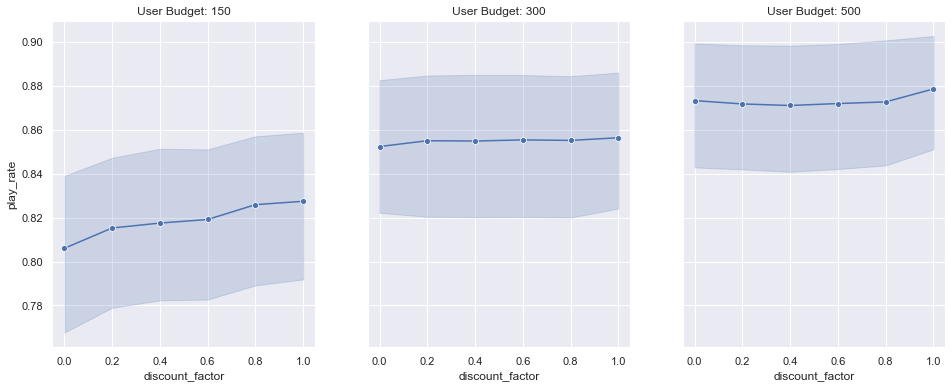

In [19]:
user_budgets = np.sort(np.unique(sarsa_results_df.user_budget))
user_budgets = [150, 300, 500]
f, axes = plt.subplots(nrows=1, ncols=len(user_budgets), figsize=(16, 6), sharex=True, sharey=True)
for n, ub in enumerate(user_budgets):
    sub_result = sarsa_results_df[sarsa_results_df.user_budget == ub].reset_index()
    sns.lineplot(ax=axes[n], data = sub_result,
                 x = 'discount_factor', y = 'play_rate', marker='o').set(title=f'User Budget: {ub}')

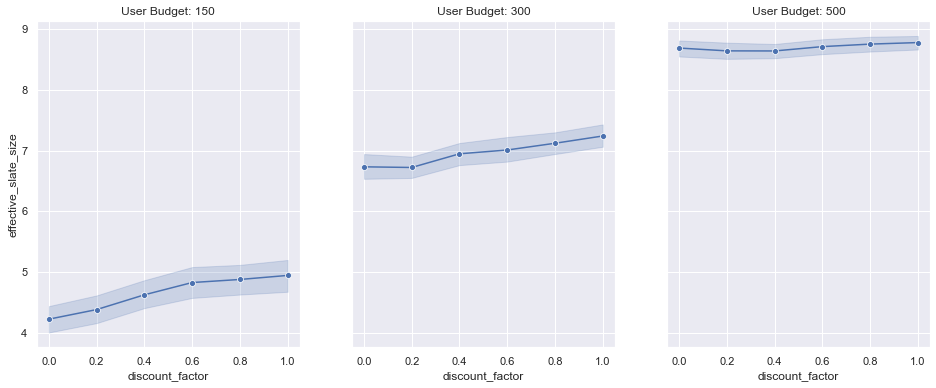

In [21]:
f, axes = plt.subplots(nrows=1, ncols=len(user_budgets), figsize=(16, 6), sharex=True, sharey=True)
for n, ub in enumerate(user_budgets):
    sub_result = sarsa_results_df[sarsa_results_df.user_budget == ub].reset_index()
    sns.lineplot(ax=axes[n], data = sub_result,
                 x = 'discount_factor', y = 'effective_slate_size', marker='o').set(title=f'User Budget: {ub}')

In [22]:
sarsa_results_df_discount_factor_0 = sarsa_results_df[sarsa_results_df.discount_factor == 0].reset_index()
sarsa_results_df_discount_factor_08 = sarsa_results_df[sarsa_results_df.discount_factor == 0.8].reset_index()

In [23]:
cb_vs_rl_df = pd.merge(sarsa_results_df_discount_factor_0,
         sarsa_results_df_discount_factor_08, on = ['user_budget', 'seed'])

In [26]:
cb_vs_rl_df['delta_play_rate'] =\
100. * (cb_vs_rl_df['play_rate_y'] - cb_vs_rl_df['play_rate_x']) / (cb_vs_rl_df['play_rate_x'])

cb_vs_rl_df['delta_effective_slate_size'] =\
100. * (cb_vs_rl_df['effective_slate_size_y'] - cb_vs_rl_df['effective_slate_size_x']) / (cb_vs_rl_df['effective_slate_size_x'])

<AxesSubplot:xlabel='user_budget', ylabel='delta_effective_slate_size'>

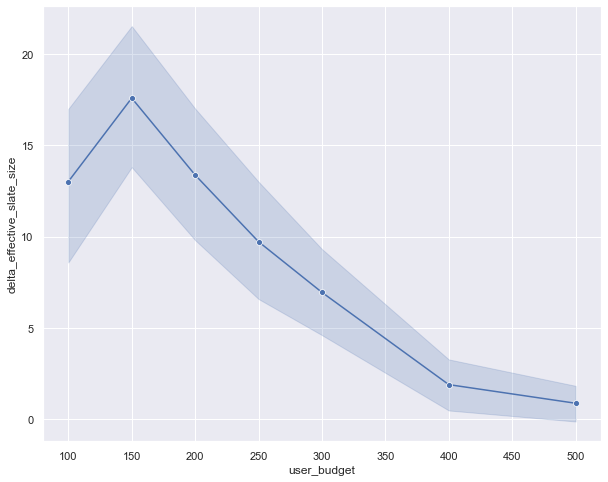

In [27]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=cb_vs_rl_df, x = 'user_budget', y = 'delta_effective_slate_size', marker = 'o')

<AxesSubplot:xlabel='user_budget', ylabel='delta_play_rate'>

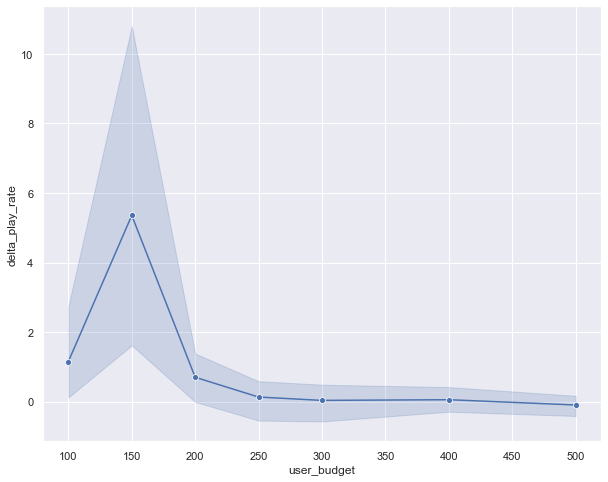

In [28]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=cb_vs_rl_df, x = 'user_budget', y = 'delta_play_rate', marker = 'o')

## Q-Learning Vs SARSA

In [30]:
results_df_q_learning_discount_factor_08 = qlearning_results_df[qlearning_results_df.discount_factor == 0.8]

In [31]:
ql_vs_sarsa_df = pd.merge(results_df_q_learning_discount_factor_08,
                          sarsa_results_df_discount_factor_08, on = ['user_budget', 'seed'])

In [32]:
ql_vs_sarsa_df['delta_play_rate'] = 100.* (ql_vs_sarsa_df['play_rate_x'] - ql_vs_sarsa_df['play_rate_y']) / ql_vs_sarsa_df['play_rate_y']

In [33]:
ql_vs_sarsa_df['delta_effective_slate_size'] =\
100 * (ql_vs_sarsa_df['effective_slate_size_x'] - ql_vs_sarsa_df['effective_slate_size_y']) / (ql_vs_sarsa_df['effective_slate_size_y'])

<AxesSubplot:xlabel='user_budget', ylabel='delta_effective_slate_size'>

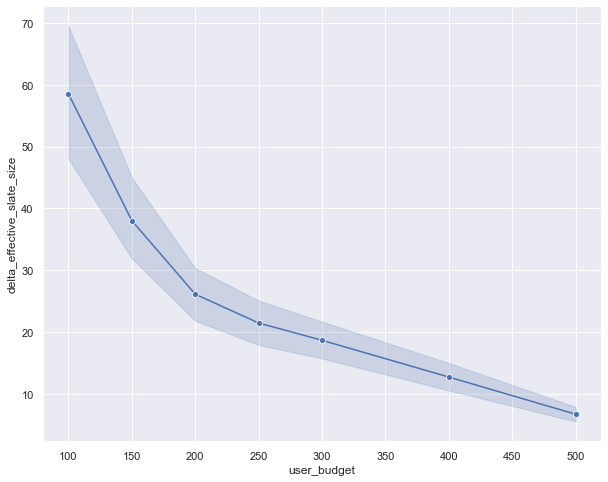

In [34]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=ql_vs_sarsa_df, x = 'user_budget', y = 'delta_effective_slate_size', marker = 'o')

<AxesSubplot:xlabel='user_budget', ylabel='delta_play_rate'>

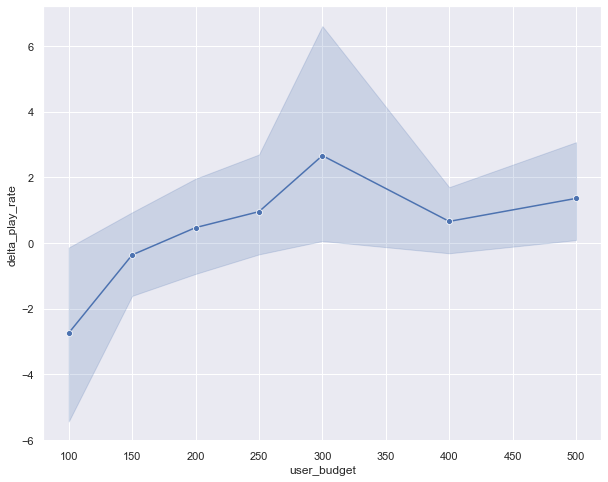

In [35]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=ql_vs_sarsa_df, x = 'user_budget', y = 'delta_play_rate', marker = 'o')